In [19]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
#import aplpy as apl #The Astronomy Plotting Library for python
import astropy
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [20]:
quasar = pyfits.getdata('NGC3783_1_10_J_new.fits')
header = pyfits.getheader('NGC3783_1_10_J_new.fits')
w = WCS('NGC3783_1_10_J_new.fits')

In [21]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [22]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later flux determination, \
    it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [35]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
    AGNdata[mask] = float(0)
    return np.trim_zeros(AGNdata)


In [36]:
apparature = 0.01
a = curve(pyfits.getdata('NGC3783_1_10_J_new.fits'),pyfits.getheader('NGC3783_1_10_J_new.fits'),WCS('NGC3783_1_10_J_new.fits'),(header['RA'],header['DEC']),apparature)

print a


plt.figure()
plt.imshow(a)
plt.colorbar()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

0.0005 2912
0.001 8099
0.0015 12483
0.002 14731
0.0025 16774
0.003 18467
0.0035 20190
0.004 21733
0.0045 23277
0.005 24370
0.0055 25244
0.006 25851
0.0065 26249
0.007 26439
0.0075 26502
0.008 26290
0.0085 26000
0.009 25670
0.0095 25174
0.01 24567


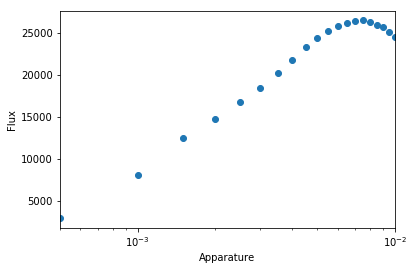

In [34]:
app = []
flux = []


for k in range(20):
    apparature = 0.0005*(k+1)
    a = curve(pyfits.getdata('NGC3783_1_10_J_new.fits'),pyfits.getheader('NGC3783_1_10_J_new.fits'),WCS('NGC3783_1_10_J_new.fits'),(header['RA'],header['DEC']),apparature)
    #print np.shape(a),np.max(a[:,:,2])
    app.append(apparature)
    flux.append(np.sum(a))
    print apparature, np.sum(a)
    

plt.figure()
plt.scatter(app,flux)
plt.xlabel('Apparature')
plt.ylabel('Flux')
plt.xscale('log')
#plt.yscale('log')
plt.xlim([0.0005,0.01])
plt.legend()
plt.show()
